In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import gc
from tqdm import tqdm

import numpy as np

import tensorflow as tf

import medim
import tfmod
from data_loaders import Brats2015, Brats2017

from utils import *
from tools import train_model, find_threshold, get_stats_and_dices

%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
log_path = '/tmp/tf'
processed_path = '/mount/export/brats2017/processed'
data_loader = Brats2017(processed_path)

patients = data_loader.patients
metadata = data_loader.metadata

spatial_size = data_loader.spatial_size
n_modalities = data_loader.n_modalities
n_chans_msegm = data_loader.n_chans_msegm
n_classes = data_loader.n_classes

train, train_val, val, test = split_data(metadata)

sd_train = metadata.iloc[train].survival_class.values
sd_train_val = metadata.iloc[train_val].survival_class.values
sd_val = metadata.iloc[val].survival_class.values
sd_test = metadata.iloc[test].survival_class.values

In [3]:
n_epoch = 100

kernel_size = 3
blocks = [n_modalities, 16, 16, 32, 32, 64]

patch_size_x = np.array([25, 25, 25])
patch_size_y = patch_size_x - 2*(len(blocks) - 1)*(kernel_size//2)
padding = (patch_size_x - patch_size_y) // 2

def make_val_inputs(x, y):
    return [[symmetry_padding(xo, padding), np.array(yo, dtype=int)]
            for xo, yo in zip(x, y)]

def get_pred_and_true(model_controller, xo, yo):
    xo = symmetry_padding(xo, padding)
    yo_true = np.array(yo, dtype=int)
    return model_controller.predict_proba([xo]), yo_true

def make_batch_iterator(x, y, batch_size):
    train_iter = medim.batch_iter.patch.foreground(
        [x, y], [patch_size_x, patch_size_y], batch_size=batch_size,
        spatial_dims=(-3, -2, -1), f_fraction=0.5, f_condition=lambda y: y > 0,
    )
    return train_iter

In [4]:
for ds, (val_set, test_set) in enumerate([[val, test], [test, val]]):
    for i in range(2):
        tf.reset_default_graph()
        model = tfmod.models.EEnet(blocks, n_classes, kernel_size)
        model_controller = tfmod.ModelController(
            model, log_path, restore_ckpt_path=None)

        
        train_idx = train + val_set
        test_idx = test_set
        
        train_model(model_controller, make_batch_iterator, make_val_inputs, data_loader,
                    train_idx, train_val, n_epoch=n_epoch)

        ckpt_path = './checkpoints/eenet_ds{}_i{}'.format(ds, i)
        
        saver = tf.train.Saver()
        saver.save(model_controller.session, ckpt_path)

Loading train data


100%|██████████| 201/201 [00:30<00:00,  6.53it/s]

Loading val data



100%|██████████| 5/5 [00:00<00:00,  6.47it/s]


Starting training
Epoch 0
Train: 0.440941
Val  : 0.0609848


Epoch 1
Train: 0.351641
Val  : 0.0528101


Epoch 2
Train: 0.344982
Val  : 0.0633783


Epoch 3
Train: 0.339405
Val  : 0.0507984


Epoch 4
Train: 0.32974
Val  : 0.0561922


Epoch 5
Train: 0.32311
Val  : 0.0561753


Epoch 6
Train: 0.327707
Val  : 0.0600741


Epoch 7
Train: 0.320471
Val  : 0.0567385


Epoch 8
Train: 0.318771
Val  : 0.047496


Epoch 9
Train: 0.319805
Val  : 0.0442345


Epoch 10
Train: 0.310217
Val  : 0.0454125


Epoch 11
Train: 0.31683
Val  : 0.0550957


Epoch 12
Train: 0.311127
Val  : 0.0721404


Epoch 13
Train: 0.31257
Val  : 0.0611179


Epoch 14
Train: 0.305504
Val  : 0.0451988


Epoch 15
Train: 0.306311
Val  : 0.0547646


Epoch 16
Train: 0.31259
Val  : 0.0516338


Epoch 17
Train: 0.312325
Val  : 0.0444297


Epoch 18
Train: 0.303368
Val  : 0.047876


Epoch 19
Train: 0.304875
Val  : 0.0476709


Epoch 20
Train: 0.297157
Val  : 0.0424234


Epoch 21
Train: 0.304932
Val  : 0.0491483


Epoch 22
Train: 0.300239
Val  :

100%|██████████| 201/201 [00:05<00:00, 61.56it/s]

Loading val data



100%|██████████| 5/5 [00:00<00:00, 61.41it/s]


Starting training
Epoch 0
Train: 0.447226
Val  : 0.0631282


Epoch 1
Train: 0.353808
Val  : 0.0885506


Epoch 2
Train: 0.355199
Val  : 0.0740194


Epoch 3
Train: 0.344584
Val  : 0.0530172


Epoch 4
Train: 0.337072
Val  : 0.0468244


Epoch 5
Train: 0.333379
Val  : 0.0645854


Epoch 6
Train: 0.330424
Val  : 0.0588043


Epoch 7
Train: 0.326189
Val  : 0.0526166


Epoch 8
Train: 0.320273
Val  : 0.0605074


Epoch 9
Train: 0.323749
Val  : 0.0533129


Epoch 10
Train: 0.321196
Val  : 0.0610682


Epoch 11
Train: 0.318322
Val  : 0.0562881


Epoch 12
Train: 0.319771
Val  : 0.0534811


Epoch 13
Train: 0.313643
Val  : 0.0528034


Epoch 14
Train: 0.30692
Val  : 0.049058


Epoch 15
Train: 0.307841
Val  : 0.0475486


Epoch 16
Train: 0.308618
Val  : 0.0454928


Epoch 17
Train: 0.303786
Val  : 0.0502615


Epoch 18
Train: 0.312991
Val  : 0.0497906


Epoch 19
Train: 0.311766
Val  : 0.0486725


Epoch 20
Train: 0.304884
Val  : 0.0497182


Epoch 21
Train: 0.304198
Val  : 0.0448444


Epoch 22
Train: 0.298249
V

100%|██████████| 196/196 [00:20<00:00,  4.17it/s]

Loading val data



100%|██████████| 5/5 [00:00<00:00, 11.63it/s]


Starting training
Epoch 0
Train: 0.463722
Val  : 0.0635492


Epoch 1
Train: 0.372998
Val  : 0.061518


Epoch 2
Train: 0.355015
Val  : 0.0638529


Epoch 3
Train: 0.343405
Val  : 0.0764


Epoch 4
Train: 0.352246
Val  : 0.0558782


Epoch 5
Train: 0.339908
Val  : 0.0555281


Epoch 6
Train: 0.333281
Val  : 0.0566658


Epoch 7
Train: 0.335245
Val  : 0.0468703


Epoch 8
Train: 0.333752
Val  : 0.0455323


Epoch 9
Train: 0.331657
Val  : 0.0558784


Epoch 10
Train: 0.323195
Val  : 0.0548872


Epoch 11
Train: 0.325378
Val  : 0.0562764


Epoch 12
Train: 0.323776
Val  : 0.0553657


Epoch 13
Train: 0.317164
Val  : 0.0435061


Epoch 14
Train: 0.31465
Val  : 0.0453053


Epoch 15
Train: 0.303975
Val  : 0.041872


Epoch 16
Train: 0.310113
Val  : 0.0518772


Epoch 17
Train: 0.308234
Val  : 0.0563507


Epoch 18
Train: 0.302028
Val  : 0.0408463


Epoch 19
Train: 0.309185
Val  : 0.0501358


Epoch 20
Train: 0.30136
Val  : 0.0460927


Epoch 21
Train: 0.304364
Val  : 0.0430437


Epoch 22
Train: 0.300486
Val  :

100%|██████████| 196/196 [00:29<00:00,  2.88it/s]

Loading val data



100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


Starting training
Epoch 0
Train: 0.444774
Val  : 0.0769457


Epoch 1
Train: 0.369964
Val  : 0.0555329


Epoch 2
Train: 0.353922
Val  : 0.0575807


Epoch 3
Train: 0.348487
Val  : 0.0565095


Epoch 4
Train: 0.33992
Val  : 0.0596078


Epoch 5
Train: 0.34373
Val  : 0.0536004


Epoch 6
Train: 0.337649
Val  : 0.0496001


Epoch 7
Train: 0.328109
Val  : 0.058407


Epoch 8
Train: 0.340882
Val  : 0.0539474


Epoch 9
Train: 0.322705
Val  : 0.049582


Epoch 10
Train: 0.325693
Val  : 0.0738641


Epoch 11
Train: 0.32897
Val  : 0.0497488


Epoch 12
Train: 0.320852
Val  : 0.0442525


Epoch 13
Train: 0.321155
Val  : 0.0415014


Epoch 14
Train: 0.313977
Val  : 0.0473045


Epoch 15
Train: 0.312282
Val  : 0.0488005


Epoch 16
Train: 0.320517
Val  : 0.0490889


Epoch 17
Train: 0.312377
Val  : 0.060196


Epoch 18
Train: 0.309127
Val  : 0.0475022


Epoch 19
Train: 0.303781
Val  : 0.0423038


Epoch 20
Train: 0.311411
Val  : 0.0560391


Epoch 21
Train: 0.310661
Val  : 0.0489215


Epoch 22
Train: 0.318764
Val  

In [4]:
all_dices = []

for ds, (val_set, test_set) in enumerate([[val, test], [test, val]]):
    for i in range(2):
        ckpt_path = './checkpoints/eenet_ds{}_i{}'.format(ds, i)
        tf.reset_default_graph()
        model = tfmod.models.EEnet(blocks, n_classes, kernel_size)
        model_controller = tfmod.ModelController(
            model, log_path, restore_ckpt_path=ckpt_path)

        test_idx = test_set
        
        threshold = find_threshold(model_controller, get_pred_and_true, data_loader, train_val)
        print('Treshold:', threshold)

        stats_pred, stats_true, dices = get_stats_and_dices(
        model_controller, get_pred_and_true, data_loader, test_idx, threshold)
        
        all_dices.append(dices)
        print(ckpt_path, np.mean(dices, axis=0))

INFO:tensorflow:Restoring parameters from ./checkpoints/eenet_ds0_i0
Loading val data


100%|██████████| 5/5 [00:00<00:00, 56.36it/s]

Starting prediction


Treshold: [ 0.52105263  0.26052632  0.88578947]
Loading val data


100%|██████████| 79/79 [00:01<00:00, 64.43it/s]

Starting prediction



79it [01:14,  1.07it/s]


./checkpoints/eenet_ds0_i0 [ 0.81887669  0.69636152  0.63352346]
INFO:tensorflow:Restoring parameters from ./checkpoints/eenet_ds0_i1
Loading val data


100%|██████████| 5/5 [00:00<00:00, 62.94it/s]

Starting prediction


Treshold: [ 0.57315789  0.36473684  0.88578947]
Loading val data


100%|██████████| 79/79 [00:01<00:00, 61.21it/s]

Starting prediction



79it [01:15,  1.04it/s]


./checkpoints/eenet_ds0_i1 [ 0.79760055  0.70064739  0.60433629]
INFO:tensorflow:Restoring parameters from ./checkpoints/eenet_ds1_i0
Loading val data


100%|██████████| 5/5 [00:00<00:00, 75.00it/s]

Starting prediction


Treshold: [ 0.57315789  0.26052632  0.93789474]
Loading val data


100%|██████████| 84/84 [00:01<00:00, 62.12it/s]

Starting prediction



84it [01:18,  1.05it/s]


./checkpoints/eenet_ds1_i0 [ 0.81316048  0.74766554  0.58358385]
INFO:tensorflow:Restoring parameters from ./checkpoints/eenet_ds1_i1
Loading val data


100%|██████████| 5/5 [00:00<00:00, 77.32it/s]

Starting prediction


Treshold: [ 0.57315789  0.36473684  0.93789474]
Loading val data


100%|██████████| 84/84 [00:01<00:00, 61.20it/s]

Starting prediction



84it [01:16,  1.11it/s]

./checkpoints/eenet_ds1_i1 [ 0.7917942   0.7589742   0.59650717]


In [7]:
[np.mean(a, axis=0) for a in all_dices]

[array([ 0.81887669,  0.69636152,  0.63352346]),
 array([ 0.79760055,  0.70064739,  0.60433629]),
 array([ 0.81316048,  0.74766554,  0.58358385]),
 array([ 0.7917942 ,  0.7589742 ,  0.59650717])]

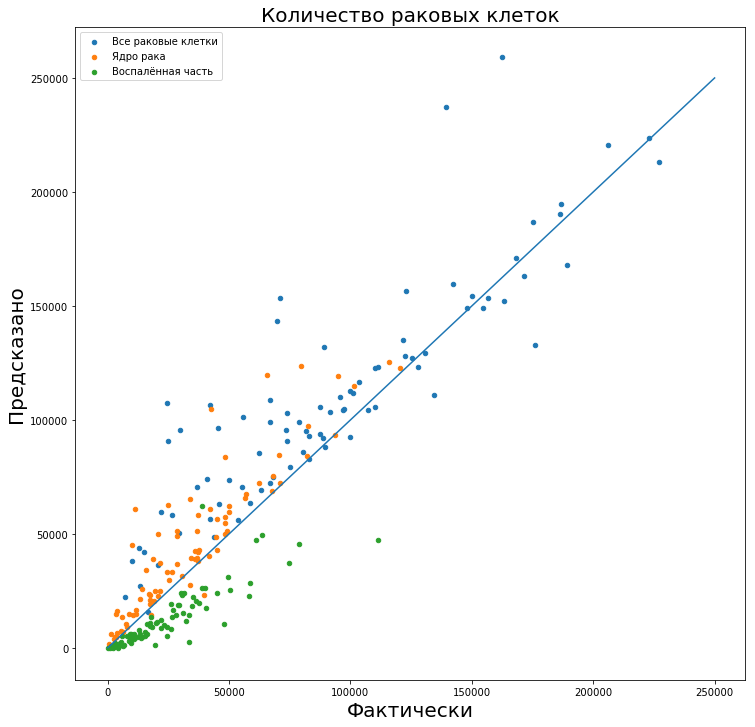

In [26]:
fig = plt.figure(figsize=(12, 12))

fontsize = 20
plt.title('Количество раковых клеток',fontsize=fontsize)
plt.xlabel('Фактически', fontsize=fontsize)
plt.ylabel('Предсказано', fontsize=fontsize)

for k, name in enumerate(['Все раковые клетки', 'Ядро рака', 'Воспалённая часть']):
    plt.scatter(stats_true[:, k], stats_pred[:, k], s=20, label=name)

    
plt.plot(np.linspace(100, 250000, 1000), np.linspace(100, 250000, 1000))
plt.legend(fontsize=fontsize//2)
plt.show()